# Generate little fly around movies

In [2]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import yt

from astropy.io import  fits

import numpy as np

from astropy.io import ascii

import sys

from matplotlib import pyplot as plt
%matplotlib inline

import os

from IPython.display import Image

from scipy.interpolate import interp1d
import spectrum

In [11]:
# render functions

def prep_data_source(FIELD, IFU, ID, fnspectrum, sigma_clip, xoff, yoff, zoff, ZERO_OUT_EVERYTHING_ELSE=False):
    name = "{}_{}_{}".format(FIELD, IFU, ID)

    outdir = "../movies/{}/".format(name)
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    name = "ifu{}_id{:5d}".format(IFU, ID)
    t = ascii.read("../data/mmsf2outcube_{}_allifu.cat".format(FIELD))
    s = spectrum.readSpectrum(fnspectrum)
    m = spectrum.readSpectrum("../data/mmap_{}_{}.fits.gz".format(FIELD,IFU))

    # load calibration
    ftcal = "../specphot/mean_cal_{}.txt".format(FIELD)
    tcal = ascii.read(ftcal, format="fixed_width")
    cal_interp = interp1d(tcal["wl[A]"], tcal["cal[erg/s/cm^2/A/cnt]"], kind='linear', bounds_error=False,fill_value="extrapolate")

    ww = s.grid()
    for i,w in enumerate(ww):
        s.data[i] = s.data[i] * cal_interp(w)/Apix * 1e17


    if ZERO_OUT_EVERYTHING_ELSE:
        # Null out everything but the object of interest
        s.data[ m.data != ID ] = 0.
        #sigma_clip = .15
        #bounds  = (0.00, 0.025)

    ii = (t['ifu'] == IFU) * (t['id'] == ID)
    if sum(ii) != 1:
        print("Could not find object for ifu = {} id = {}.".format(IFU,ID))
        sys.exit(0)
    r = t[ii][0]

    x0,x1 = r['xmin']-xp+xoff, r['xmax']+xp+xoff
    y0,y1 = r['ymin']-yp+yoff, r['ymax']+yp+yoff
    z0,z1 = r['zmin']-zp+zoff, r['zmax']+zp+zoff

    print("x0,x1 = ", x0,x1)
    print("y0,y1 = ", y0,y1)
    print("z0,z1 = ", z0,z1)

    subcube = s.data[z0:z1,y0:y1,x0:x1]

    print("min: ", subcube.min())
    print("max: ", subcube.max())
    print("std: ", subcube.std())

    s.hdu.data = subcube
    s.hdu.writeto(os.path.join(outdir, 'tmp.fits'), overwrite=True)

    ds = yt.load(os.path.join(outdir, 'tmp.fits'))


    print("ds.domain_center: ", ds.domain_center)
    
    return ds, outdir


def prep_data_source_not_catalog(FIELD, IFU, ID, fnspectrum, sigma_clip, x0,x1,y0,y1,z0,z1, ZERO_OUT_EVERYTHING_ELSE=False):
    name = "{}_{}_{}".format(FIELD, IFU, ID)

    outdir = "../movies/{}/".format(name)
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    name = "ifu{}_id{}".format(IFU, ID)
    s = spectrum.readSpectrum(fnspectrum)
    m = spectrum.readSpectrum("../data/map_{}_{}.fits.gz".format(FIELD,IFU))

    # load calibration
    ftcal = "../specphot/mean_cal_{}.txt".format(FIELD)
    tcal = ascii.read(ftcal, format="fixed_width")
    cal_interp = interp1d(tcal["wl[A]"], tcal["cal[erg/s/cm^2/A/cnt]"], kind='linear', bounds_error=False,fill_value="extrapolate")

    ww = s.grid()
    for i,w in enumerate(ww):
        s.data[i] = s.data[i] * cal_interp(w)/Apix * 1e17


    if ZERO_OUT_EVERYTHING_ELSE:
        # Null out everything but the object of interest
        s.data[ m.data != ID ] = 0.
        #sigma_clip = .15
        #bounds  = (0.00, 0.025)

    subcube = s.data[z0:z1,y0:y1,x0:x1]

    print("min: ", subcube.min())
    print("max: ", subcube.max())
    print("std: ", subcube.std())

    s.hdu.data = subcube
    s.hdu.writeto(os.path.join(outdir, 'tmp.fits'), overwrite=True)

    ds = yt.load(os.path.join(outdir, 'tmp.fits'))


    print("ds.domain_center: ", ds.domain_center)
    
    return ds, outdir

def initial_render(ds, bounds, nlayer, widths, alpha, camwidth, outdir, sigma_clip, cmap='octarine', start_pos=None):
    
    sc = yt.create_scene(ds, lens_type='perspective', field='image_0')

    # Get a reference to the VolumeSource associated with this scene
    # It is the first source associated with the scene, so we can refer to it
    # using index 0.
    source = sc[0]

    if True:
        source.set_log(False)

        # Since this rendering is done in log space, the transfer function needs
        # to be specified in log space.
        tf = yt.ColorTransferFunction(bounds)
        #tf.add_layers(nlayer, w=widths, alpha=alpha, colormap='octarine')
        tf.add_layers(nlayer, w=widths, alpha=alpha, colormap=cmap)
        plt.cm.CMRmap
        source.tfh.tf = tf
        source.tfh.bounds = bounds
        source.tfh.grey_opacity = True
      
    if type(start_pos) == type(None):
        start_pos = ds.domain_center *  (1.,1.,5.)


    cam = sc.camera
    cam.focus = ds.domain_center
    cam.position = start_pos
    cam.north_vector = ds.arr([.0,  1., 0.], 'code_length')
    cam.width = camwidth
    cam.switch_orientation()

    # increase the default resolution
    cam.resolution = (800, 800)


    # set the camera to use "steady_north"

    # Plot the transfer function, along with the CDF of the density field to
    # see how the transfer function corresponds to structure in the CDF
    source.tfh.plot( fn=os.path.join(outdir, 'transfer_function.png'), profile_field='image_0')

    sc.annotate_axes()
    
    
    # Draw the domain boundary
    sc.annotate_domain(ds, color=[1, 1, 1, 0.01])
    sc.save(os.path.join(outdir, "%s_vr_domain.png" % ds), sigma_clip=sigma_clip)

    # Draw the grid boundaries
    sc.annotate_grids(ds, alpha=0.01)
    sc.save(os.path.join(outdir, "%s_vr_grids.png" % ds), sigma_clip=sigma_clip)

    # Draw a coordinate axes triad
    sc.annotate_axes(alpha=0.01)
    sc.save(os.path.join(outdir, "%s_vr_coords.png" % ds), sigma_clip=sigma_clip)



    # save the image, flooring especially bright pixels for better contrast
    sc.save(os.path.join(outdir, 'rendering.png'), sigma_clip=sigma_clip)
    
    return ds, sc, cam, tf, outdir 


def render_movie(sc, cam, outdir, n_samples):
    # Now create movie
    cam.steady_north = True
    source = sc[0]
    source.tfh.plot(outdir + '/transfer_function.png', profile_field='image_0')


    for i in range(n_samples + 1):
        #sc.annotate_axes()

        #cam.yaw(2.*np.pi/n_samples/72., rot_center=cam.position)
        #cam.rotate(2.*np.pi/n_samples, rot_center=np.array([0.0, 0.0, 0.0]))


        #ds.domain_center
        #cam.yaw(2.*np.pi/n_samples, rot_center=np.array([(0.1,unitary)0.47647059,0.50588235] ))
        #cam.switch_orientation()
        #sc.render()
        sc.save(outdir + '/rendering{:02d}.png'.format(i), sigma_clip=sigma_clip)
        cam.steady_north = True
        cam.rotate(2.*np.pi/n_samples, rot_vector=[0.0, 1.0, 0.0], rot_center=ds.domain_center)

    

In [12]:
def create_colorbar(fn, bounds, cmap):
    fig = plt.figure(figsize=[2.5,7])
    ax = fig.add_axes([0.1,0.1,0.3,0.85])
    #ax = plt.subplot(111)

    val_min,val_max = bounds

    # colorbar
    a = np.outer(np.arange(val_min,val_max,(val_max-val_min)/100.),np.ones(10))

    ax.imshow(a,aspect='auto',cmap=cmap,origin="lower",extent=(10,20,val_min,val_max))
    print( "val_min,val_max", val_min,val_max)

    ax.yaxis.set_ticks_position("right") # ticks and ticklabels
    ax.yaxis.set_label_position("right") # axis label

    xticklabels = ax.get_xticklabels()
    ax.set_xticks([])

    ax.set_ylabel( "flux [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ arcsec$^{-2}$]", color='white')
    
    ax.set_facecolor('xkcd:black')
    fig.patch.set_facecolor('xkcd:black')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    fig.savefig(fn, facecolor='k')
    


min:  -0.026052378031288417
max:  0.049295037026063526
std:  0.0053455020307540384


yt : [WARNING  ] 2019-08-02 09:16:56,249 Cannot find time
yt : [INFO     ] 2019-08-02 09:16:56,252 Detected these axes: RA---TAN DEC--TAN Wave 
yt : [WARNING  ] 2019-08-02 09:16:56,255 No length conversion provided. Assuming 1 = 1 cm.
yt : [INFO     ] 2019-08-02 09:16:56,266 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-08-02 09:16:56,267 Parameters: domain_dimensions         = [80 66 90]
yt : [INFO     ] 2019-08-02 09:16:56,268 Parameters: domain_left_edge          = [0.5 0.5 0.5]
yt : [INFO     ] 2019-08-02 09:16:56,269 Parameters: domain_right_edge         = [80.5 66.5 90.5]
yt : [INFO     ] 2019-08-02 09:16:56,270 Parameters: cosmological_simulation   = 0.0


ds.domain_center:  [40.5 33.5 45.5] code_length


yt : [INFO     ] 2019-08-02 09:16:56,299 Adding field image_0 to the list of fields.
yt : [WARNING  ] 2019-08-02 09:16:56,300 Could not determine dimensions for field image_0, setting to dimensionless.
yt : [INFO     ] 2019-08-02 09:16:56,849 Rendering scene (Can take a while).
yt : [INFO     ] 2019-08-02 09:16:56,861 Creating volume
yt : [INFO     ] 2019-08-02 09:17:11,671 Saving render ../movies/COSMOSA_022_HTLAB1/tmp.fits_vr_domain.png
/Users/mxhf/ownCloudRZG/work/MPE/hetdex/src/deep_and_repeat/COSMOS/yt_gitclone/yt/units/yt_array.py:1394: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
yt : [INFO     ] 2019-08-02 09:17:12,512 Rendering scene (Can take a while).
yt : [INFO     ] 2019-08-02 09:17:27,576 Saving render ../movies/COSMOSA_022_HTLAB1/tmp.fits_vr_grids.png
yt : [INFO     ] 2019-08-02 09:17:28,403 Rendering scene (Can take a while).
yt : [INFO     ] 2019-08-02 09:17:42,992 Saving render ../movies/COSMOSA_022_HTLAB1/tmp.fits_vr_coords.png
yt : [

val_min,val_max 0.0061 0.05


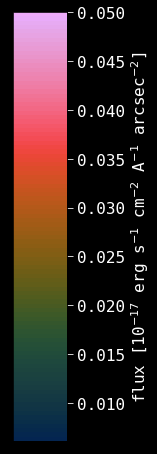

In [13]:
# HTLAB1
FIELD = "COSMOSA"
IFU = "022"
ID = "HTLAB1"

x0,x1 = 65,120
y0,y1 = 23,78
z0,z1 = 160,200


x0,x1 = 49,129
yo,y1 =  9,89
z0,z1 = 128,218



camwidth = (50., 'code_length')
bounds = (0.15, 0.7) 
bounds  = (0.0061, 0.05)
NLAYER = 9
alpha = np.linspace(.1,1.,nlayer)
widths =  0.0000001
n_samples = 180
sigma_clip = .4
start_pos = [(80.5/2., 'code_length'), (80.5/2., 'code_length'), (125.5, 'code_length')]
# pixal area in sq arcsec
Apix = 0.5**2.

cmap = 'octarine'
fnspectrum = "../data/sf2outcube_{}_{}.fits.gz".format(FIELD,IFU)


ds, outdir = prep_data_source_not_catalog(FIELD, IFU, ID, fnspectrum, sigma_clip, x0,x1,y0,y1,z0,z1, ZERO_OUT_EVERYTHING_ELSE=False)
ds, sc, cam, tf, outdir =  initial_render(ds, bounds, nlayer, widths, alpha, camwidth, outdir, sigma_clip,cmap=cmap, start_pos=start_pos)
Image(os.path.join(outdir, 'rendering.png'))
#render_movie(sc, cam, outdir, n_samples=15)
#render_movie(sc, cam, outdir, n_samples=n_samples)

create_colorbar(os.path.join(outdir,"colormap.png"), bounds, cmap)


min:  -0.026052378031288417
max:  0.049295037026063526
std:  0.0053455020307540384


yt : [WARNING  ] 2019-08-02 09:40:06,107 Cannot find time
yt : [INFO     ] 2019-08-02 09:40:06,110 Detected these axes: RA---TAN DEC--TAN Wave 
yt : [WARNING  ] 2019-08-02 09:40:06,119 No length conversion provided. Assuming 1 = 1 cm.
yt : [INFO     ] 2019-08-02 09:40:06,139 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-08-02 09:40:06,140 Parameters: domain_dimensions         = [80 66 90]
yt : [INFO     ] 2019-08-02 09:40:06,142 Parameters: domain_left_edge          = [0.5 0.5 0.5]
yt : [INFO     ] 2019-08-02 09:40:06,144 Parameters: domain_right_edge         = [80.5 66.5 90.5]
yt : [INFO     ] 2019-08-02 09:40:06,145 Parameters: cosmological_simulation   = 0.0


ds.domain_center:  [40.5 33.5 45.5] code_length


yt : [INFO     ] 2019-08-02 09:40:06,197 Adding field image_0 to the list of fields.
yt : [WARNING  ] 2019-08-02 09:40:06,199 Could not determine dimensions for field image_0, setting to dimensionless.
yt : [INFO     ] 2019-08-02 09:40:07,114 Rendering scene (Can take a while).
yt : [INFO     ] 2019-08-02 09:40:07,134 Creating volume
yt : [INFO     ] 2019-08-02 09:40:16,082 Saving render ../movies/COSMOSA_022_HTLAB1/tmp.fits_vr_domain.png


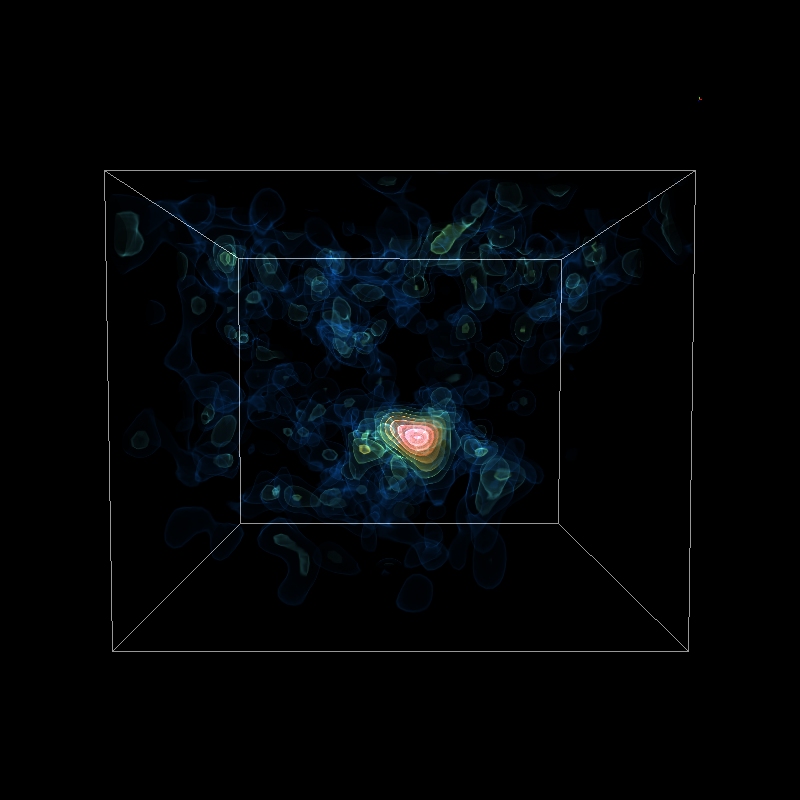

In [34]:
# a bit of messing around with coordinate axes etc

from yt.visualization.volume_rendering.api import LineSource
from yt.units import kpc


# HTLAB1
FIELD = "COSMOSA"
IFU = "022"
ID = "HTLAB1"

x0,x1 = 65,120
y0,y1 = 23,78
z0,z1 = 160,200


x0,x1 = 49,129
yo,y1 =  9,89
z0,z1 = 128,218



camwidth = (10., 'code_length')
bounds = (0.15, 0.7) 
bounds  = (0.0061, 0.05)
NLAYER = 9
alpha = np.linspace(.1,1.,nlayer)
widths =  0.0000001
n_samples = 180
sigma_clip = .4
start_pos = [(80.5/2., 'code_length'), (80.5/2., 'code_length'), (200., 'code_length')]
# pixal area in sq arcsec
Apix = 0.5**2.

cmap = 'octarine'
fnspectrum = "../data/sf2outcube_{}_{}.fits.gz".format(FIELD,IFU)


ds, outdir = prep_data_source_not_catalog(FIELD, IFU, ID, fnspectrum, sigma_clip, x0,x1,y0,y1,z0,z1, ZERO_OUT_EVERYTHING_ELSE=False)



sc = yt.create_scene(ds, lens_type='perspective', field='image_0')

# Get a reference to the VolumeSource associated with this scene
# It is the first source associated with the scene, so we can refer to it
# using index 0.
source = sc[0]

if True:
    source.set_log(False)

    # Since this rendering is done in log space, the transfer function needs
    # to be specified in log space.
    tf = yt.ColorTransferFunction(bounds)
    #tf.add_layers(nlayer, w=widths, alpha=alpha, colormap='octarine')
    tf.add_layers(nlayer, w=widths, alpha=alpha, colormap=cmap)
    plt.cm.CMRmap
    source.tfh.tf = tf
    source.tfh.bounds = bounds
    source.tfh.grey_opacity = True

if type(start_pos) == type(None):
    start_pos = ds.domain_center *  (1.,1.,5.)


cam = sc.camera
cam.focus = ds.domain_center
cam.position = start_pos
cam.north_vector = ds.arr([.0,  1., 0.], 'code_length')
cam.width = camwidth
cam.switch_orientation()

# increase the default resolution
cam.resolution = (800, 800)


# set the camera to use "steady_north"

# Plot the transfer function, along with the CDF of the density field to
# see how the transfer function corresponds to structure in the CDF
source.tfh.plot( fn=os.path.join(outdir, 'transfer_function.png'), profile_field='image_0')

sc.annotate_axes()


# You may need to adjust the alpha values to get an image with good contrast.
# For the annotate_domain call, the fourth value in the color tuple is the
# alpha value.
#sc.annotate_axes(alpha=.02)
#sc.annotate_domain(ds, color=[1, 1, 1, .01])

text_string = "T = {} Gyr".format(float(ds.current_time.to('Gyr')))


# Draw the domain boundary
sc.annotate_domain(ds, color=[1, 1, 1, 0.001])


# play with lines
nlines = 50
vertices = (np.random.random([nlines, 2, 3]) - 0.5) * 200 
colors = np.random.random([nlines, 4])
colors[:, 3] = 0.1

lines = LineSource(vertices, colors)
#sc.add_source(lines)



#sc.annotate_axes(alpha=1.)
#sc.annotate_domain(ds, color=[1, 1, 1, 1])
# save an annotated version of the volume rendering including a representation
# of the transfer function and a nice label showing the simulation time.
#sc.save_annotated(os.path.join(outdir, "%s_vr_domain.png" % ds), sigma_clip=sigma_clip,
#                  text_annotate=[[(.1, 0.95), text_string]])

sc.save(os.path.join(outdir, "%s_vr_domain.png" % ds), sigma_clip=sigma_clip)

Image(os.path.join(outdir, "%s_vr_domain.png" % ds))

In [35]:
sc.annotate_axes?

In [ ]:
# HTLAB3
IFU = 106
ID = 58
ID = "HTLAB3"

t = ascii.read("../dat/COSMOSA_{}.txt".format(IFU))
hdu = fits.open("data/sf2outcube_median_{}.fits.gz".format(ID))

ii = t['id'] == ID
r = t[ii][0]

xp,yp,zp=20,20,20

x0,x1 = r['xmin']-xp, r['xmax']+xp
y0,y1 = r['ymin']-yp, r['ymax']+yp
z0,z1 = r['zmin']-zp, r['zmax']+zp
camwidth = (50., 'code_length')



subcube = hdu[0].data[z0:z1,y0:y1,x0:x1]
#subcube[18:20,18:20,18:20] = 10.
hdu[0].data = subcube
hdu.writeto("tmp.fits", overwrite=True)

bounds = (0.12, 1.2)
NLAYER = 7
alpha = np.linspace(.1,1.,NLAYER)
widths =  0.0002
n_samples = 180

sigma_clip=.25
#start_pos = [(69.5/2., 'code_length'), (61.5/2., 'code_length'), (125.5, 'code_length')]

outdir = "movies/HDLAB3/"

ds = yt.load('tmp.fits')


start_pos = ds.domain_center *  (1.,1.,4.)

In [1]:
# top filament in BW
FIELD = "COSMOSC"
IFU = "025"
ID = 10018
# padding around source
xp,yp,zp=[8]*3
# center offset
xoff,yoff,zoff = 0,0,0
# camera field of view
camwidth = (30., 'code_length')
nlayer = 9
alpha = np.linspace(.1,1.,nlayer)
widths =  0.0000001
n_samples = 180
bounds  = (0.0061, 0.025)
sigma_clip = .5
# pixal area in sq arcsec
Apix = 0.5**2.

#cmap = plt.cm.CMRmap
cmap = plt.cm.Greys
fnspectrum = "../data/sf2outcube_{}_{}.fits.gz".format(FIELD,IFU)

ds, outdir = prep_data_source(FIELD, IFU, ID, fnspectrum, sigma_clip, xoff, yoff, zoff, ZERO_OUT_EVERYTHING_ELSE=False)
ds, sc, cam, tf, outdir =  initial_render(ds, bounds, nlayer, widths, alpha, camwidth, outdir, sigma_clip,cmap=cmap)
Image(os.path.join(outdir, 'rendering.png'))
#render_movie(sc, cam, outdir, n_samples=15)
#render_movie(sc, cam, outdir, n_samples=90)

create_colorbar(os.path.join(outdir,"colormap.png"), bounds, cmap)
Image(os.path.join(outdir, 'colormap.png'))

NameError: name 'np' is not defined

x0,x1 =  82 118
y0,y1 =  30 93
z0,z1 =  387 427
min:  -0.017041600843548207
max:  0.02162003431216786
std:  0.004798991134495469


yt : [WARNING  ] 2019-07-27 08:08:00,376 Cannot find time
yt : [INFO     ] 2019-07-27 08:08:00,377 Detected these axes: RA---TAN DEC--TAN Wave 
yt : [WARNING  ] 2019-07-27 08:08:00,380 No length conversion provided. Assuming 1 = 1 cm.
yt : [INFO     ] 2019-07-27 08:08:00,389 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-07-27 08:08:00,390 Parameters: domain_dimensions         = [36 63 40]
yt : [INFO     ] 2019-07-27 08:08:00,391 Parameters: domain_left_edge          = [0.5 0.5 0.5]
yt : [INFO     ] 2019-07-27 08:08:00,392 Parameters: domain_right_edge         = [36.5 63.5 40.5]
yt : [INFO     ] 2019-07-27 08:08:00,393 Parameters: cosmological_simulation   = 0.0


ds.domain_center:  [18.5 32.  20.5] code_length


yt : [INFO     ] 2019-07-27 08:08:00,420 Adding field image_0 to the list of fields.
yt : [WARNING  ] 2019-07-27 08:08:00,421 Could not determine dimensions for field image_0, setting to dimensionless.
yt : [INFO     ] 2019-07-27 08:08:01,059 Rendering scene (Can take a while).
yt : [INFO     ] 2019-07-27 08:08:01,064 Creating volume
yt : [INFO     ] 2019-07-27 08:08:04,080 Saving render ../movies/COSMOSC_025_10018/rendering.png


val_min,val_max 0.0061 0.025


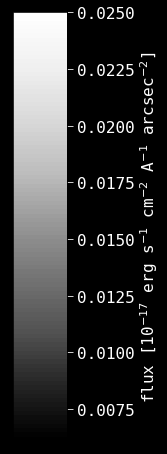

In [108]:
# top filament
FIELD = "COSMOSC"
IFU = "025"
ID = 10018
# padding around source
xp,yp,zp=[8]*3
# center offset
xoff,yoff,zoff = 0,0,0
# camera field of view
camwidth = (30., 'code_length')
nlayer = 9
alpha = np.linspace(.1,1.,nlayer)
widths =  0.0000001
n_samples = 180
bounds  = (0.0061, 0.025)
sigma_clip = .5
# pixal area in sq arcsec
Apix = 0.5**2.

#cmap = plt.cm.CMRmap
cmap = 'octarine'
fnspectrum = "../data/sf2outcube_{}_{}.fits.gz".format(FIELD,IFU)

ds, outdir = prep_data_source(FIELD, IFU, ID, fnspectrum, sigma_clip, xoff, yoff, zoff, ZERO_OUT_EVERYTHING_ELSE=False)


ds, sc, cam, tf, outdir =  initial_render(ds, bounds, nlayer, widths, alpha, camwidth, outdir, sigma_clip,cmap=cmap)
Image(os.path.join(outdir, 'rendering.png'))
#render_movie(sc, cam, outdir, n_samples=15)
#render_movie(sc, cam, outdir, n_samples=90)

create_colorbar(os.path.join(outdir,"colormap.png"), bounds, cmap)
#Image(os.path.join(outdir, 'colormap.png'))



#fig.savefig(fn, facecolor='k')

x0,x1 =  85 117
y0,y1 =  88 120
z0,z1 =  555 592
min:  -0.011504291032108054
max:  0.18318960665683967
std:  0.01003098808670155


yt : [WARNING  ] 2019-07-26 17:47:33,569 Cannot find time
yt : [INFO     ] 2019-07-26 17:47:33,570 Detected these axes: RA---TAN DEC--TAN Wave 
yt : [WARNING  ] 2019-07-26 17:47:33,573 No length conversion provided. Assuming 1 = 1 cm.
yt : [INFO     ] 2019-07-26 17:47:33,582 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-07-26 17:47:33,583 Parameters: domain_dimensions         = [32 32 37]
yt : [INFO     ] 2019-07-26 17:47:33,584 Parameters: domain_left_edge          = [0.5 0.5 0.5]
yt : [INFO     ] 2019-07-26 17:47:33,585 Parameters: domain_right_edge         = [32.5 32.5 37.5]
yt : [INFO     ] 2019-07-26 17:47:33,587 Parameters: cosmological_simulation   = 0.0


ds.domain_center:  [16.5 16.5 19. ] code_length


yt : [INFO     ] 2019-07-26 17:47:33,616 Adding field image_0 to the list of fields.
yt : [WARNING  ] 2019-07-26 17:47:33,617 Could not determine dimensions for field image_0, setting to dimensionless.
yt : [INFO     ] 2019-07-26 17:47:34,051 Rendering scene (Can take a while).
yt : [INFO     ] 2019-07-26 17:47:34,055 Creating volume
yt : [INFO     ] 2019-07-26 17:47:35,357 Saving render ../movies/COSMOSC_042_5049/rendering.png


val_min,val_max 0.008 0.1


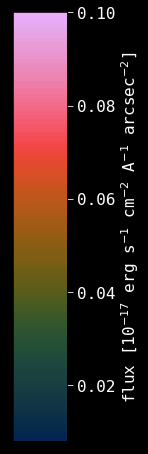

In [106]:
### AGN with halo
FIELD = "COSMOSC"
IFU = "042"
ID = 5049
# padding around source
xp,yp,zp=[10]*3
# center offset
xoff,yoff,zoff = 0,0,0
# camera field of view
camwidth = (30., 'code_length')
nlayer = 9
alpha = np.linspace(.25,1.,nlayer)
n_samples = 180
bounds  = (0.008, .1)
widths =  (bounds[1]-bounds[0])/189000.0
sigma_clip = .1
# pixal area in sq arcsec
Apix = 0.5**2.

cmap = 'octarine'
fnspectrum = "../data/sf2outcube_{}_{}.fits.gz".format(FIELD,IFU)

ds, outdir = prep_data_source(FIELD, IFU, ID, fnspectrum, sigma_clip, xoff, yoff, zoff, ZERO_OUT_EVERYTHING_ELSE=False)
ds, sc, cam, tf, outdir =  initial_render(ds, bounds, nlayer, widths, alpha, camwidth, outdir, sigma_clip, cmap=cmap)
Image(os.path.join(outdir, 'rendering.png'))
#render_movie(sc, cam, outdir, n_samples=15)
#render_movie(sc, cam, outdir, n_samples=90)


create_colorbar(os.path.join(outdir,"colormap.png"), bounds, cmap)

x0,x1 =  0 41
y0,y1 =  36 86
z0,z1 =  510 551
min:  -0.02044870790897817
max:  0.02091919958372769
std:  0.004620665949684742


yt : [WARNING  ] 2019-07-26 15:29:58,228 Cannot find time
yt : [INFO     ] 2019-07-26 15:29:58,231 Detected these axes: RA---TAN DEC--TAN Wave 
yt : [WARNING  ] 2019-07-26 15:29:58,235 No length conversion provided. Assuming 1 = 1 cm.
yt : [INFO     ] 2019-07-26 15:29:58,245 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-07-26 15:29:58,245 Parameters: domain_dimensions         = [41 50 41]
yt : [INFO     ] 2019-07-26 15:29:58,246 Parameters: domain_left_edge          = [0.5 0.5 0.5]
yt : [INFO     ] 2019-07-26 15:29:58,248 Parameters: domain_right_edge         = [41.5 50.5 41.5]
yt : [INFO     ] 2019-07-26 15:29:58,248 Parameters: cosmological_simulation   = 0.0


ds.domain_center:  [21.  25.5 21. ] code_length


yt : [INFO     ] 2019-07-26 15:29:58,278 Adding field image_0 to the list of fields.
yt : [WARNING  ] 2019-07-26 15:29:58,279 Could not determine dimensions for field image_0, setting to dimensionless.
yt : [INFO     ] 2019-07-26 15:29:58,800 Rendering scene (Can take a while).
yt : [INFO     ] 2019-07-26 15:29:58,803 Creating volume
yt : [INFO     ] 2019-07-26 15:30:01,393 Saving render ../movies/COSMOSC_087_5032/rendering.png


val_min,val_max 0.008 0.02


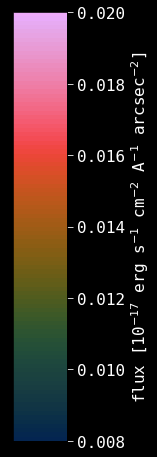

In [90]:
# filament
FIELD = "COSMOSC"
IFU = "087"
ID = 5032
# padding around source
xp,yp,zp=[16]*3
# center offset
xoff,yoff,zoff = 0,0,0
# camera field of view
camwidth = (30., 'code_length')
nlayer = 9
alpha = np.linspace(.15,1.,nlayer)
widths =  0.0000001
n_samples = 180
bounds  = (0.008, 0.02)
sigma_clip = .9
# pixal area in sq arcsec
Apix = 0.5**2.

cmap = 'octarine'
fnspectrum = "../data/sf2outcube_{}_{}.fits.gz".format(FIELD,IFU)

ds, outdir = prep_data_source(FIELD, IFU, ID, fnspectrum, sigma_clip, xoff, yoff, zoff, ZERO_OUT_EVERYTHING_ELSE=False)
ds, sc, cam, tf, outdir =  initial_render(ds, bounds, nlayer, widths, alpha, camwidth, outdir, sigma_clip, cmap=cmap)
Image(os.path.join(outdir, 'rendering.png'))
#render_movie(sc, cam, outdir, n_samples=15)
#render_movie(sc, cam, outdir, n_samples=90)

create_colorbar(os.path.join(outdir,"colormap.png"), bounds, cmap)

x0,x1 =  38 86
y0,y1 =  58 109
z0,z1 =  832 881
min:  -0.022427485726515633
max:  0.017999390219148738
std:  0.004930460186493514


yt : [WARNING  ] 2019-07-26 17:44:17,243 Cannot find time
yt : [INFO     ] 2019-07-26 17:44:17,244 Detected these axes: RA---TAN DEC--TAN Wave 
yt : [WARNING  ] 2019-07-26 17:44:17,248 No length conversion provided. Assuming 1 = 1 cm.
yt : [INFO     ] 2019-07-26 17:44:17,257 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-07-26 17:44:17,257 Parameters: domain_dimensions         = [48 51 49]
yt : [INFO     ] 2019-07-26 17:44:17,258 Parameters: domain_left_edge          = [0.5 0.5 0.5]
yt : [INFO     ] 2019-07-26 17:44:17,259 Parameters: domain_right_edge         = [48.5 51.5 49.5]
yt : [INFO     ] 2019-07-26 17:44:17,260 Parameters: cosmological_simulation   = 0.0


ds.domain_center:  [24.5 26.  25. ] code_length


yt : [INFO     ] 2019-07-26 17:44:17,288 Adding field image_0 to the list of fields.
yt : [WARNING  ] 2019-07-26 17:44:17,289 Could not determine dimensions for field image_0, setting to dimensionless.
yt : [INFO     ] 2019-07-26 17:44:17,731 Rendering scene (Can take a while).
yt : [INFO     ] 2019-07-26 17:44:17,738 Creating volume
yt : [INFO     ] 2019-07-26 17:44:20,001 Saving render ../movies/COSMOSC_093_10016/rendering.png


val_min,val_max 0.006 0.025


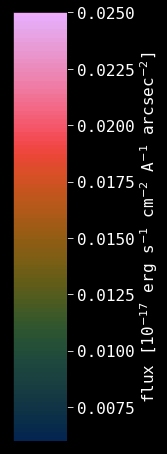

In [104]:
# halo
FIELD = "COSMOSC"
IFU = "093"
ID = 10016
# padding around source
xp,yp,zp=[17]*3
# center offset
xoff,yoff,zoff = 0,0,0
# camera field of view
camwidth = (30., 'code_length')
nlayer = 9
alpha = np.linspace(.15,1.,nlayer)
widths =  0.0000001
n_samples = 180
bounds  = (0.006, 0.025)
sigma_clip = .2
# pixal area in sq arcsec
Apix = 0.5**2.

cmap = 'octarine'
fnspectrum = "../data/sf2outcube_{}_{}.fits.gz".format(FIELD,IFU)

ds, outdir = prep_data_source(FIELD, IFU, ID, fnspectrum, sigma_clip, xoff, yoff, zoff, ZERO_OUT_EVERYTHING_ELSE=False)
ds, sc, cam, tf, outdir =  initial_render(ds, bounds, nlayer, widths, alpha, camwidth, outdir, sigma_clip, cmap=cmap)
Image(os.path.join(outdir, 'rendering.png'))
#render_movie(sc, cam, outdir, n_samples=15)
#render_movie(sc, cam, outdir, n_samples=90)

create_colorbar(os.path.join(outdir,"colormap.png"), bounds, cmap)

x0,x1 =  17 54
y0,y1 =  22 59
z0,z1 =  120 154
min:  -0.03395700155936423
max:  0.1177413355931774
std:  0.013302925636984785


yt : [WARNING  ] 2019-07-26 17:42:52,791 Cannot find time
yt : [INFO     ] 2019-07-26 17:42:52,792 Detected these axes: RA---TAN DEC--TAN Wave 
yt : [WARNING  ] 2019-07-26 17:42:52,795 No length conversion provided. Assuming 1 = 1 cm.
yt : [INFO     ] 2019-07-26 17:42:52,804 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-07-26 17:42:52,805 Parameters: domain_dimensions         = [37 37 34]
yt : [INFO     ] 2019-07-26 17:42:52,806 Parameters: domain_left_edge          = [0.5 0.5 0.5]
yt : [INFO     ] 2019-07-26 17:42:52,807 Parameters: domain_right_edge         = [37.5 37.5 34.5]
yt : [INFO     ] 2019-07-26 17:42:52,808 Parameters: cosmological_simulation   = 0.0


ds.domain_center:  [19.  19.  17.5] code_length


yt : [INFO     ] 2019-07-26 17:42:52,842 Adding field image_0 to the list of fields.
yt : [WARNING  ] 2019-07-26 17:42:52,843 Could not determine dimensions for field image_0, setting to dimensionless.
yt : [INFO     ] 2019-07-26 17:42:53,450 Rendering scene (Can take a while).
yt : [INFO     ] 2019-07-26 17:42:53,455 Creating volume
yt : [INFO     ] 2019-07-26 17:42:55,652 Saving render ../movies/COSMOSC_097_5009/rendering.png


val_min,val_max 0.008 0.12


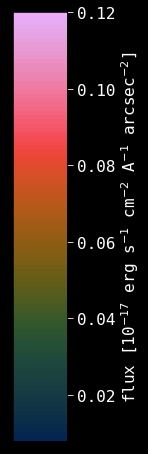

In [103]:
# AGN with halo
FIELD = "COSMOSC"
IFU = "097"
ID = 5009
# padding around source
xp,yp,zp=[10]*3
# center offset
xoff,yoff,zoff = 0,0,0
# camera field of view
camwidth = (30., 'code_length')
nlayer = 9
alpha = np.linspace(.1,1.,nlayer)
n_samples = 180
bounds  = (0.008, .12)
widths =  (bounds[1]-bounds[0])/189000.0
sigma_clip = .35
# pixal area in sq arcsec
Apix = 0.5**2.

cmap = 'octarine'
fnspectrum = "../data/sf2nomaskoutcube_COSMOSC_097.fits.gz"

ds, outdir = prep_data_source(FIELD, IFU, ID, fnspectrum, sigma_clip, xoff, yoff, zoff, ZERO_OUT_EVERYTHING_ELSE=False)
ds, sc, cam, tf, outdir =  initial_render(ds, bounds, nlayer, widths, alpha, camwidth, outdir, sigma_clip, cmap=cmap)
Image(os.path.join(outdir, 'rendering.png'))
#render_movie(sc, cam, outdir, n_samples=15)
#render_movie(sc, cam, outdir, n_samples=90)

create_colorbar(os.path.join(outdir,"colormap.png"), bounds, cmap)

x0,x1 =  81 126
y0,y1 =  24 68
z0,z1 =  357 401
min:  -0.042665125035440926
max:  0.03438781497342306
std:  0.006243444213843783


yt : [WARNING  ] 2019-07-26 17:39:38,793 Cannot find time
yt : [INFO     ] 2019-07-26 17:39:38,794 Detected these axes: RA---TAN DEC--TAN Wave 
yt : [WARNING  ] 2019-07-26 17:39:38,798 No length conversion provided. Assuming 1 = 1 cm.
yt : [INFO     ] 2019-07-26 17:39:38,807 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-07-26 17:39:38,808 Parameters: domain_dimensions         = [45 44 44]
yt : [INFO     ] 2019-07-26 17:39:38,809 Parameters: domain_left_edge          = [0.5 0.5 0.5]
yt : [INFO     ] 2019-07-26 17:39:38,810 Parameters: domain_right_edge         = [45.5 44.5 44.5]
yt : [INFO     ] 2019-07-26 17:39:38,811 Parameters: cosmological_simulation   = 0.0


ds.domain_center:  [23.  22.5 22.5] code_length


yt : [INFO     ] 2019-07-26 17:39:38,839 Adding field image_0 to the list of fields.
yt : [WARNING  ] 2019-07-26 17:39:38,840 Could not determine dimensions for field image_0, setting to dimensionless.
yt : [INFO     ] 2019-07-26 17:39:39,344 Rendering scene (Can take a while).
yt : [INFO     ] 2019-07-26 17:39:39,348 Creating volume
yt : [INFO     ] 2019-07-26 17:39:41,632 Saving render ../movies/COSMOSC_105_5025/rendering.png


val_min,val_max 0.008 0.04


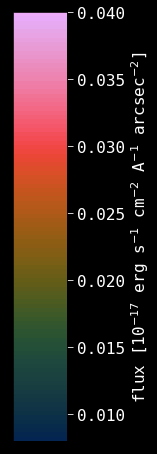

In [102]:
# halo
FIELD = "COSMOSC"
IFU = "105"
ID = 5025
# padding around source
xp,yp,zp=[17]*3
# center offset
xoff,yoff,zoff = 0,0,0
# camera field of view
camwidth = (30., 'code_length')
nlayer = 9
alpha = np.linspace(.05,1.,nlayer)
widths =  0.0000001
n_samples = 180
bounds  = (0.008, 0.04)
sigma_clip = .2
# pixal area in sq arcsec
Apix = 0.5**2.

cmap = 'octarine'
fnspectrum = "../data/sf2outcube_{}_{}.fits.gz".format(FIELD,IFU)

ds, outdir = prep_data_source(FIELD, IFU, ID, fnspectrum, sigma_clip, xoff, yoff, zoff, ZERO_OUT_EVERYTHING_ELSE=False)
ds, sc, cam, tf, outdir =  initial_render(ds, bounds, nlayer, widths, alpha, camwidth, outdir, sigma_clip, cmap=cmap)
Image(os.path.join(outdir, 'rendering.png'))
#render_movie(sc, cam, outdir, n_samples=15)
#render_movie(sc, cam, outdir, n_samples=90)

create_colorbar(os.path.join(outdir,"colormap.png"), bounds, cmap)

x0,x1 =  71 130
y0,y1 =  49 116
z0,z1 =  421 480
min:  -0.021021170045653344
max:  0.028015015027933427
std:  0.005026181380864614


yt : [WARNING  ] 2019-07-26 17:46:31,593 Cannot find time
yt : [INFO     ] 2019-07-26 17:46:31,594 Detected these axes: RA---TAN DEC--TAN Wave 
yt : [WARNING  ] 2019-07-26 17:46:31,599 No length conversion provided. Assuming 1 = 1 cm.
yt : [INFO     ] 2019-07-26 17:46:31,609 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-07-26 17:46:31,609 Parameters: domain_dimensions         = [59 67 59]
yt : [INFO     ] 2019-07-26 17:46:31,610 Parameters: domain_left_edge          = [0.5 0.5 0.5]
yt : [INFO     ] 2019-07-26 17:46:31,611 Parameters: domain_right_edge         = [59.5 67.5 59.5]
yt : [INFO     ] 2019-07-26 17:46:31,612 Parameters: cosmological_simulation   = 0.0


ds.domain_center:  [30. 34. 30.] code_length


yt : [INFO     ] 2019-07-26 17:46:31,646 Adding field image_0 to the list of fields.
yt : [WARNING  ] 2019-07-26 17:46:31,647 Could not determine dimensions for field image_0, setting to dimensionless.
yt : [INFO     ] 2019-07-26 17:46:32,100 Rendering scene (Can take a while).
yt : [INFO     ] 2019-07-26 17:46:32,106 Creating volume
yt : [INFO     ] 2019-07-26 17:46:35,410 Saving render ../movies/COSMOSC_032_10021/rendering.png


val_min,val_max 0.0061 0.025


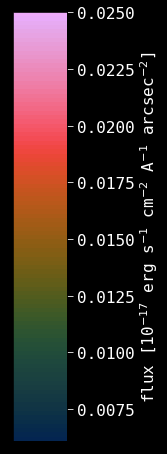

In [105]:
# filament
FIELD = "COSMOSC"
IFU = "032"
ID = 10021
# padding around source
xp,yp,zp=[13]*3
# center offset
xoff,yoff,zoff = 0,0,0
# camera field of view
camwidth = (30., 'code_length')
nlayer = 9
alpha = np.linspace(.1,1.,nlayer)
widths =  0.0000001
n_samples = 180
bounds  = (0.0061, 0.025)
sigma_clip = .5
# pixal area in sq arcsec
Apix = 0.5**2.

cmap = 'octarine'
fnspectrum = "../data/sf2outcube_{}_{}.fits.gz".format(FIELD,IFU)

ds, outdir = prep_data_source(FIELD, IFU, ID, fnspectrum, sigma_clip, xoff, yoff, zoff, ZERO_OUT_EVERYTHING_ELSE=False)
ds, sc, cam, tf, outdir =  initial_render(ds, bounds, nlayer, widths, alpha, camwidth, outdir, sigma_clip, cmap=cmap)
Image(os.path.join(outdir, 'rendering.png'))
#render_movie(sc, cam, outdir, n_samples=15)
#render_movie(sc, cam, outdir, n_samples=90)

create_colorbar(os.path.join(outdir,"colormap.png"), bounds, cmap)

#  working YT example

yt : [INFO     ] 2019-07-25 15:21:58,268 Parameters: current_time              = 150.81659738754
yt : [INFO     ] 2019-07-25 15:21:58,269 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2019-07-25 15:21:58,269 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-07-25 15:21:58,270 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2019-07-25 15:21:58,271 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2019-07-25 15:21:58,272 Parameters: current_redshift          = 0.45966304374501
yt : [INFO     ] 2019-07-25 15:21:58,272 Parameters: omega_lambda              = 0.727
yt : [INFO     ] 2019-07-25 15:21:58,273 Parameters: omega_matter              = 0.273
yt : [INFO     ] 2019-07-25 15:21:58,274 Parameters: hubble_constant           = 0.702
Parsing Hierarchy : 100%|██████████| 143/143 [00:00<00:00, 12514.30it/s]
yt : [INFO     ] 2019-07-25 15:21:58,295 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-

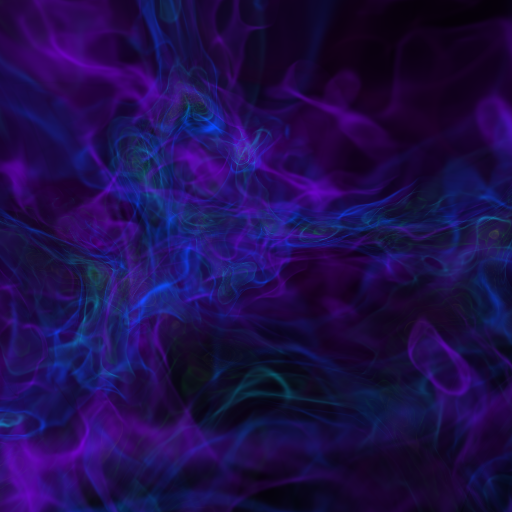

In [66]:
import yt

ds = yt.load('../yt_examples/enzo_tiny_cosmology/DD0030/DD0030')

sc = yt.create_scene(ds, lens_type='perspective')

# Get a reference to the VolumeSource associated with this scene
# It is the first source associated with the scene, so we can refer to it
# using index 0.
source = sc[0]

# Set the bounds of the transfer function
source.tfh.set_bounds((3e-31, 1e-27))

# set that the transfer function should be evaluated in log space
source.tfh.set_log(True)

# Make underdense regions appear opaque
source.tfh.grey_opacity = True

# Plot the transfer function, along with the CDF of the density field to
# see how the transfer function corresponds to structure in the CDF
source.tfh.plot('transfer_function.png', profile_field='density')

# save the image, flooring especially bright pixels for better contrast
sc.save('rendering.png', sigma_clip=6.0)


from IPython.display import Image
Image('rendering.png')

In [33]:
from IPython.parallel import Client
c = Client()
lv = c.load_balanced_view()   # this object represents the engines (workers)


def render_movie(sc, cam, outdir, n_samples):
    # Now create movie
    cam.steady_north = True
    source = sc[0]
    source.tfh.plot(outdir + '/transfer_function.png', profile_field='image_0')


    for i in range(n_samples + 1):
        #sc.annotate_axes()

        #cam.yaw(2.*np.pi/n_samples/72., rot_center=cam.position)
        #cam.rotate(2.*np.pi/n_samples, rot_center=np.array([0.0, 0.0, 0.0]))


        #ds.domain_center
        #cam.yaw(2.*np.pi/n_samples, rot_center=np.array([(0.1,unitary)0.47647059,0.50588235] ))
        #cam.switch_orientation()
        #sc.render()
        sc.save(outdir + '/rendering{:02d}.png'.format(i), sigma_clip=sigma_clip)
        cam.steady_north = True
        cam.rotate(2.*np.pi/n_samples, rot_vector=[0.0, 1.0, 0.0], rot_center=ds.domain_center)
        
# run detect and segmentation`
def build_detect_noise_model(f, DRYRUN=False):
    import os
    cmd = "python ../../filter_cube.py -i {} -o {}".format(f,f)
    os.chdir("/Users/mxhf/ownCloudRZG/work/MPE/hetdex/src/deep_and_repeat/COSMOS/data/splits")
    if DRYRUN:
        print(cmd)
        return -1, cmd
    else:
        return os.path.abspath( os.curdir ),os.system( cmd ), cmd

ff = np.sort( glob.glob("outcube_COSMOSC_split?_???.fits.gz") )

tasks = []
for f in ff:
    tasks.append(lv.apply(build_detect_noise_model, f))
result = [task.get() for task in tasks]  # blocks until all results are back

for r in result:
   print(r)      

/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.